In [1]:

import tensorflow as tf

import tf_silent
from pinn import PINN
from network import Network
from optimizer_sep_losses import L_BFGS_B

2025-07-31 14:16:11.839780: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-31 14:16:11.881621: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-31 14:16:11.881660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-31 14:16:11.882811: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-31 14:16:11.890513: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

def enhanced_wake_metrics(x_grid, y_grid, u, v, p, model_name=""):
    """
    Comprehensive wake region analysis for Kármán vortices detection
    """
    # Define wake region (adjust as needed)
    wake_x_start = 0.6  # just behind cylinder
    wake_x_end = 1.5
    wake_y_center = 0.5
    wake_y_half_width = 0.3
    
    # Create wake mask
    wake_mask = ((x_grid >= wake_x_start) & (x_grid <= wake_x_end) & 
                 (y_grid >= wake_y_center - wake_y_half_width) & 
                 (y_grid <= wake_y_center + wake_y_half_width))
    
    metrics = {}
    
    # 1. Minimum velocity in wake (your current metric)
    u_wake = u[wake_mask]
    metrics['min_u_wake'] = float(np.min(u_wake))
    metrics['mean_u_wake'] = float(np.mean(u_wake))
    
    # 2. Vorticity magnitude in wake region
    # Calculate vorticity: ω = ∂v/∂x - ∂u/∂y
    dy = y_grid[1, 0] - y_grid[0, 0]
    dx = x_grid[0, 1] - x_grid[0, 0]
    
    du_dy = np.gradient(u, dy, axis=0)
    dv_dx = np.gradient(v, dx, axis=1)
    vorticity = dv_dx - du_dy
    
    vorticity_wake = vorticity[wake_mask]
    metrics['max_vorticity_magnitude'] = float(np.max(np.abs(vorticity_wake)))
    metrics['mean_vorticity_magnitude'] = float(np.mean(np.abs(vorticity_wake)))
    
    # 3. Velocity fluctuation analysis (indicator of unsteady behavior)
    # Check for alternating positive/negative regions
    centerline_idx = np.argmin(np.abs(y_grid[:, 0] - 0.5))
    u_centerline = u[centerline_idx, :]
    x_centerline = x_grid[centerline_idx, :]
    
    # Focus on wake region along centerline
    wake_centerline_mask = (x_centerline >= wake_x_start) & (x_centerline <= wake_x_end)
    u_wake_centerline = u_centerline[wake_centerline_mask]
    x_wake_centerline = x_centerline[wake_centerline_mask]
    
    # Count zero crossings (sign changes) in wake
    sign_changes = np.sum(np.diff(np.sign(u_wake_centerline)) != 0)
    metrics['wake_sign_changes'] = int(sign_changes)
    
    # 4. Recirculation length estimation
    # Find where u becomes positive again after the cylinder
    recirculation_length = 0
    for i, x_val in enumerate(x_wake_centerline):
        if u_wake_centerline[i] > 0.01:  # threshold for positive flow
            recirculation_length = x_val - 0.6  # distance from cylinder rear
            break
    metrics['recirculation_length'] = float(recirculation_length)
    
    # 5. Wake asymmetry metric
    # Compare upper and lower wake regions
    upper_wake_mask = ((x_grid >= wake_x_start) & (x_grid <= wake_x_end) & 
                       (y_grid >= wake_y_center) & (y_grid <= wake_y_center + wake_y_half_width))
    lower_wake_mask = ((x_grid >= wake_x_start) & (x_grid <= wake_x_end) & 
                       (y_grid >= wake_y_center - wake_y_half_width) & (y_grid <= wake_y_center))
    
    u_upper = np.mean(u[upper_wake_mask])
    u_lower = np.mean(u[lower_wake_mask])
    metrics['wake_asymmetry'] = float(abs(u_upper - u_lower))
    
    return metrics

# Apply to all your models
def analyze_all_models():
    """Analyze all saved models with enhanced metrics"""
    
    # Load the training summary
    with open('model_data/track_sep_losses/all_training_summary.json', 'r') as f:
        results = json.load(f)
    
    enhanced_results = []
    
    for result in results:
        model_path = result['model_filename']
        loss_weights = result['loss_weights']
        cyl_weight = loss_weights[-1]  # Last index is cylinder boundary weight
        
        print(f"Analyzing model with cylinder weight: {cyl_weight}")
        
        # Load model and predict
        # from tensorflow.keras.models import load_model # tf.keras.models.load_model
        network = tf.keras.models.load_model(model_path)
        
        # Create inference grid
        x = np.linspace(0, 2, 300)
        y = np.linspace(0, 1, 300)
        x_grid, y_grid = np.meshgrid(x, y)
        xy_flat = np.stack([x_grid.flatten(), y_grid.flatten()], axis=-1)
        
        # Predict
        u_v_p = network.predict(xy_flat, batch_size=len(xy_flat))
        u = u_v_p[..., 0].reshape(x_grid.shape)
        v = u_v_p[..., 1].reshape(x_grid.shape)
        p = u_v_p[..., 2].reshape(x_grid.shape)
        
        # Calculate enhanced metrics
        enhanced_metrics = enhanced_wake_metrics(x_grid, y_grid, u, v, p, 
                                               model_name=f"cyl_weight_{cyl_weight}")
        
        # Combine with existing results
        enhanced_result = result.copy()
        enhanced_result.update(enhanced_metrics)
        enhanced_results.append(enhanced_result)
    
    return enhanced_results

# Run the analysis
enhanced_results = analyze_all_models()

Analyzing model with cylinder weight: 10.0


2025-07-31 14:16:17.173080: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-31 14:16:17.175466: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-31 14:16:17.176691: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

1/1 [==============================] - 0s 157ms/step
Analyzing model with cylinder weight: 20.0
1/1 [==============================] - 0s 79ms/step
Analyzing model with cylinder weight: 20.0
1/1 [==============================] - 0s 79ms/step
Analyzing model with cylinder weight: 30.0
Analyzing model with cylinder weight: 30.0
1/1 [==============================] - 0s 117ms/step
Analyzing model with cylinder weight: 60.0
Analyzing model with cylinder weight: 60.0
1/1 [==============================] - 0s 80ms/step


In [3]:
def analyze_component_losses():
    """Analyze how cylinder boundary loss changes with weight"""
    
    with open('model_data/track_sep_losses/all_training_summary.json', 'r') as f:
        results = json.load(f)
    
    loss_analysis = []
    
    for result in results:
        loss_weights = result['loss_weights']
        cyl_weight = loss_weights[-1]  # Cylinder boundary weight
        model_name = result['model_filename'].split('/')[-1].replace('.keras', '')
        
        # Load component losses
        component_loss_file = f"model_data/track_sep_losses/cyl{int(cyl_weight)}/{model_name}_component_losses.npy"
        
        try:
            component_losses = np.load(component_loss_file, allow_pickle=True)
            
            # Extract cylinder boundary loss (last component, index -1)
            cyl_losses = []
            for iteration_losses in component_losses:
                if iteration_losses is not None and len(iteration_losses) > 0:
                    cyl_losses.append(iteration_losses[-1])  # Last component is cylinder
            
            if cyl_losses:
                initial_cyl_loss = cyl_losses[0]
                final_cyl_loss = cyl_losses[-1]
                min_cyl_loss = min(cyl_losses)
                
                reduction_ratio = (initial_cyl_loss - final_cyl_loss) / initial_cyl_loss
                
                loss_analysis.append({
                    'cyl_weight': cyl_weight,
                    'initial_cyl_loss': initial_cyl_loss,
                    'final_cyl_loss': final_cyl_loss,
                    'min_cyl_loss': min_cyl_loss,
                    'loss_reduction_ratio': reduction_ratio,
                    'cyl_loss_history': cyl_losses
                })
        
        except FileNotFoundError:
            print(f"Component loss file not found for {model_name}")
    
    return loss_analysis

# Run component loss analysis
loss_analysis = analyze_component_losses()

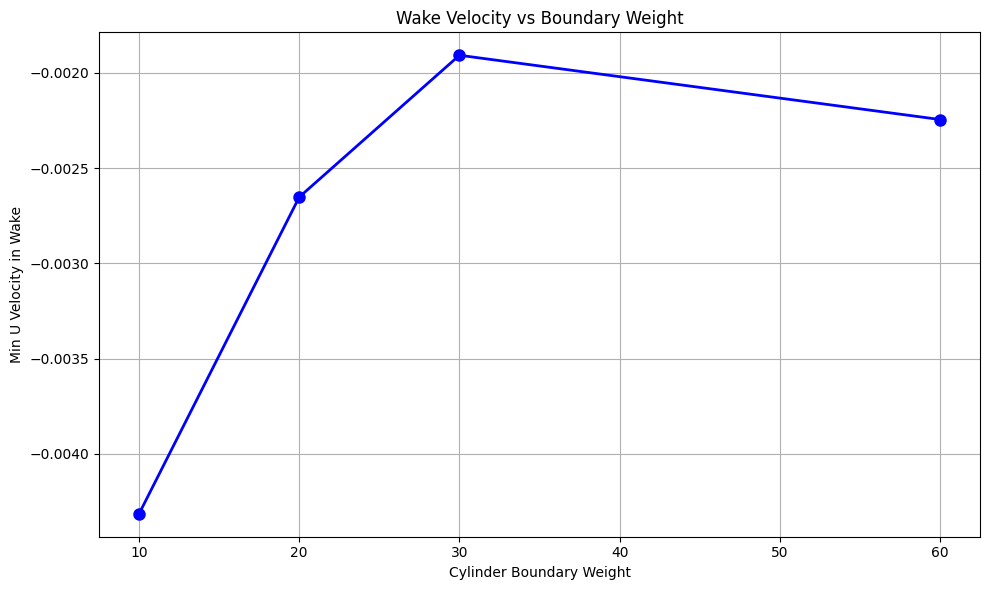

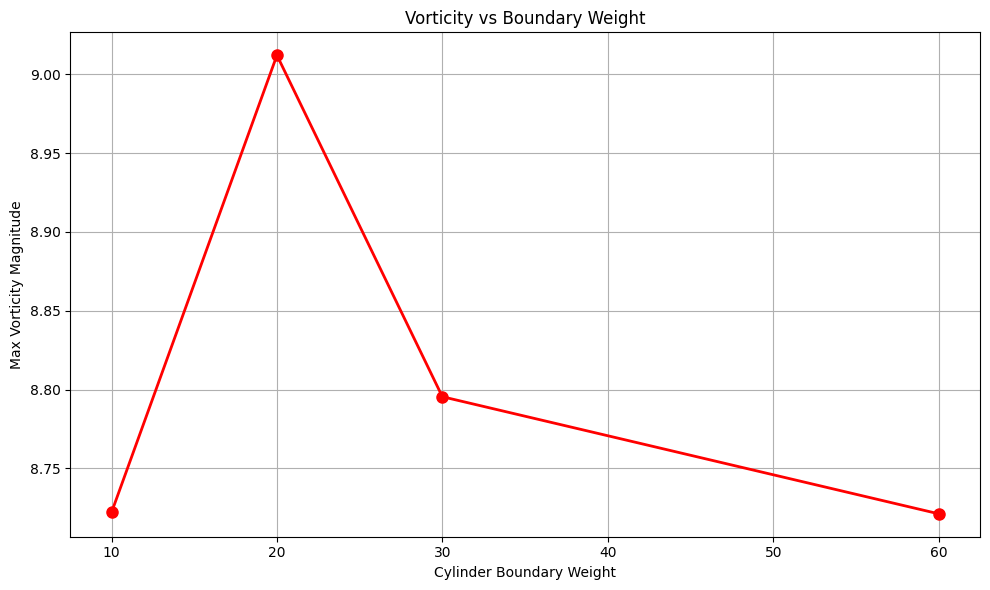

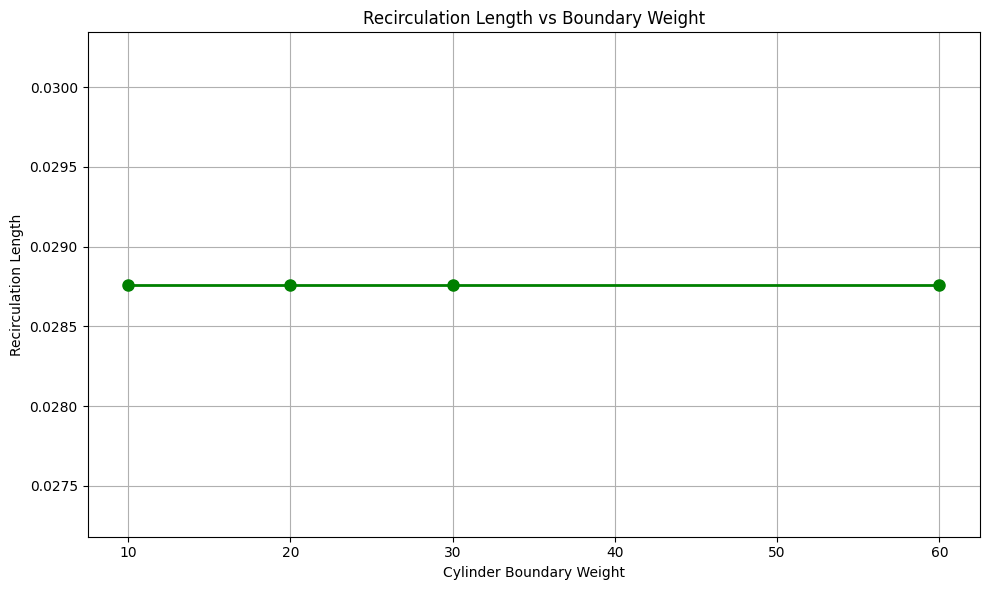

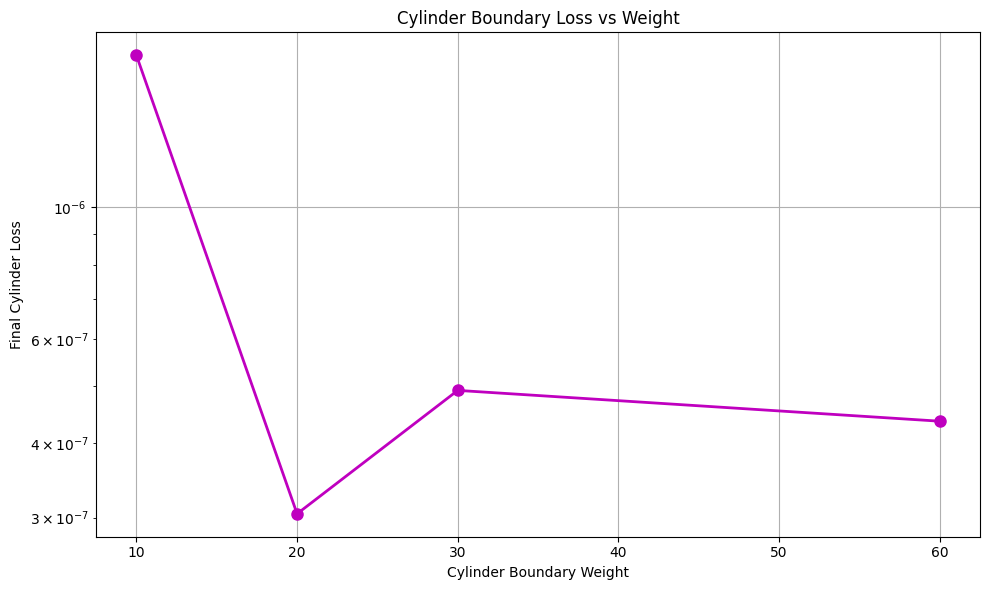

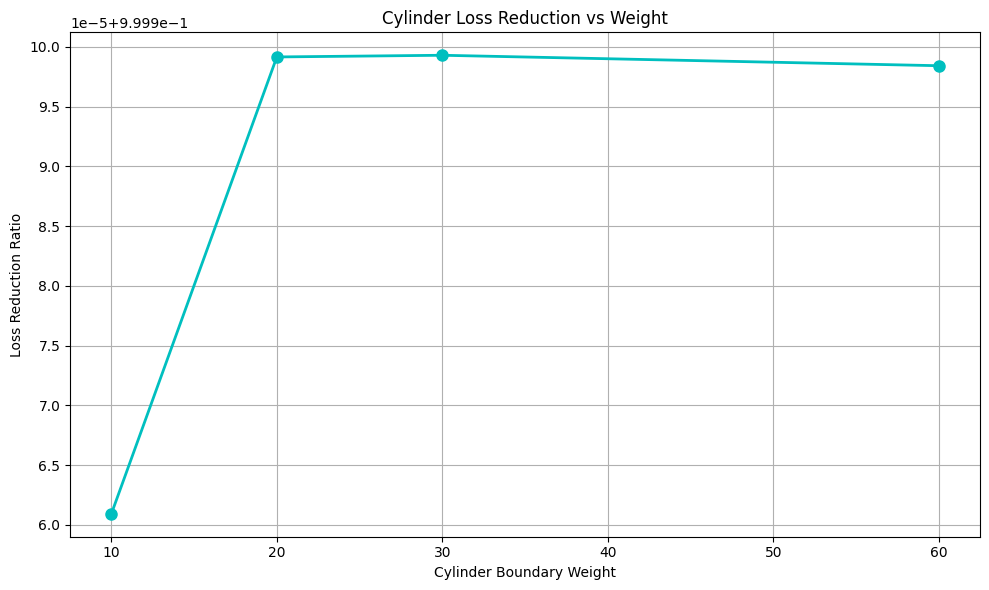

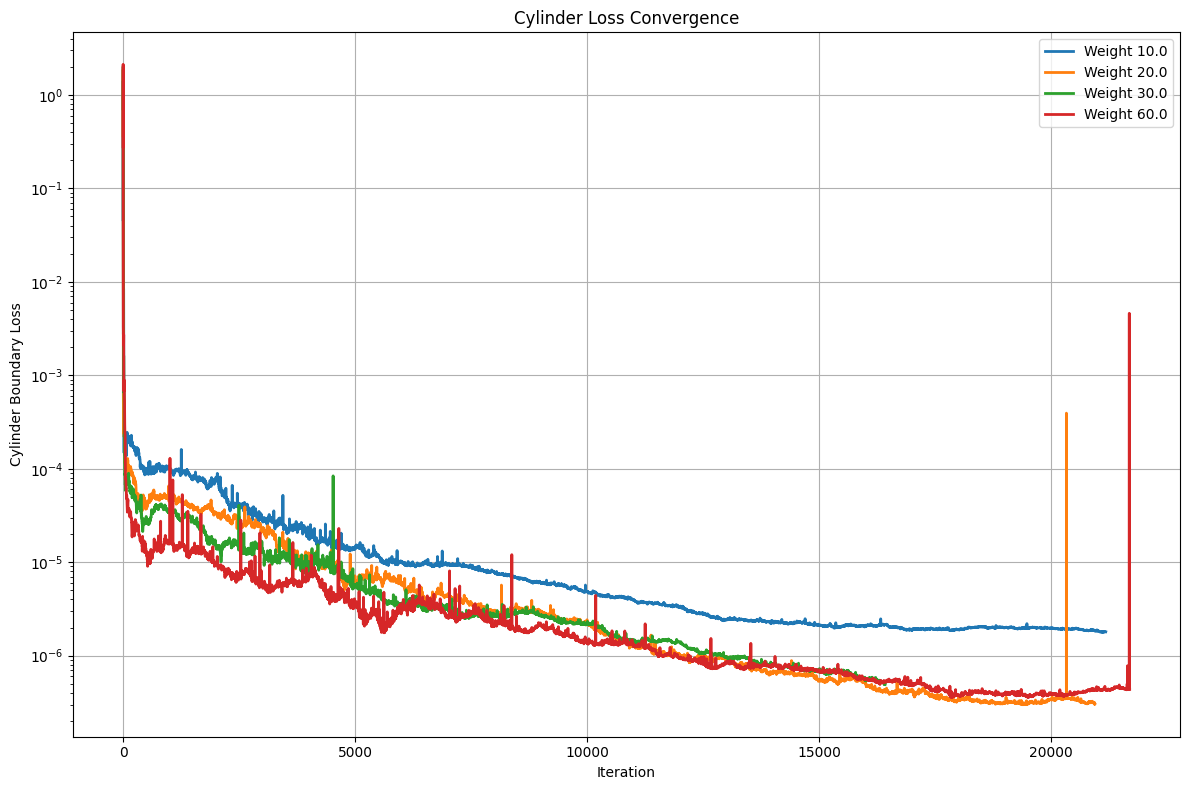

In [4]:
def create_comprehensive_analysis_plots(enhanced_results, loss_analysis):
    """Create comprehensive plots for model comparison"""
    
    # Extract data for plotting
    cyl_weights = [r['loss_weights'][-1] for r in enhanced_results]
    
    # 1. Wake velocity plot
    min_u_wake = [r['min_u_wake'] for r in enhanced_results]
    plt.figure(figsize=(10, 6))
    plt.plot(cyl_weights, min_u_wake, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Cylinder Boundary Weight')
    plt.ylabel('Min U Velocity in Wake')
    plt.title('Wake Velocity vs Boundary Weight')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('wake_velocity_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Vorticity plot
    max_vorticity = [r['max_vorticity_magnitude'] for r in enhanced_results]
    plt.figure(figsize=(10, 6))
    plt.plot(cyl_weights, max_vorticity, 'ro-', linewidth=2, markersize=8)
    plt.xlabel('Cylinder Boundary Weight')
    plt.ylabel('Max Vorticity Magnitude')
    plt.title('Vorticity vs Boundary Weight')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('vorticity_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Recirculation length plot
    recirculation_length = [r['recirculation_length'] for r in enhanced_results]
    plt.figure(figsize=(10, 6))
    plt.plot(cyl_weights, recirculation_length, 'go-', linewidth=2, markersize=8)
    plt.xlabel('Cylinder Boundary Weight')
    plt.ylabel('Recirculation Length')
    plt.title('Recirculation Length vs Boundary Weight')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('recirculation_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4. Component loss analysis plots
    if loss_analysis:
        loss_cyl_weights = [la['cyl_weight'] for la in loss_analysis]
        final_cyl_losses = [la['final_cyl_loss'] for la in loss_analysis]
        reduction_ratios = [la['loss_reduction_ratio'] for la in loss_analysis]
        
        # Final cylinder loss plot
        plt.figure(figsize=(10, 6))
        plt.plot(loss_cyl_weights, final_cyl_losses, 'mo-', linewidth=2, markersize=8)
        plt.xlabel('Cylinder Boundary Weight')
        plt.ylabel('Final Cylinder Loss')
        plt.title('Cylinder Boundary Loss vs Weight')
        plt.yscale('log')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('final_cylinder_loss.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Loss reduction ratio plot
        plt.figure(figsize=(10, 6))
        plt.plot(loss_cyl_weights, reduction_ratios, 'co-', linewidth=2, markersize=8)
        plt.xlabel('Cylinder Boundary Weight')
        plt.ylabel('Loss Reduction Ratio')
        plt.title('Cylinder Loss Reduction vs Weight')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('loss_reduction_ratio.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Loss convergence curves plot
        plt.figure(figsize=(12, 8))
        for la in loss_analysis:
            iterations = range(len(la['cyl_loss_history']))
            plt.plot(iterations, la['cyl_loss_history'], 
                    label=f"Weight {la['cyl_weight']}", linewidth=2)
        
        plt.xlabel('Iteration')
        plt.ylabel('Cylinder Boundary Loss')
        plt.title('Cylinder Loss Convergence')
        plt.yscale('log')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('loss_convergence.png', dpi=300, bbox_inches='tight')
        plt.show()

# Create the comprehensive analysis
create_comprehensive_analysis_plots(enhanced_results, loss_analysis)

In [5]:
def karman_vortex_score(x_grid, y_grid, u, v):
    """
    Calculate a score indicating likelihood of Kármán vortex formation
    Higher score = more likely to have vortex shedding
    """
    # Calculate vorticity
    dy = y_grid[1, 0] - y_grid[0, 0]
    dx = x_grid[0, 1] - x_grid[0, 0]
    
    du_dy = np.gradient(u, dy, axis=0)
    dv_dx = np.gradient(v, dx, axis=1)
    vorticity = dv_dx - du_dy
    
    # Define wake region
    wake_mask = ((x_grid >= 0.6) & (x_grid <= 1.5) & 
                 (y_grid >= 0.2) & (y_grid <= 0.8))
    
    vorticity_wake = vorticity[wake_mask]
    
    # Score components:
    # 1. Vorticity strength
    vorticity_score = np.std(vorticity_wake) * 10
    
    # 2. Alternating pattern (check for positive and negative vorticity regions)
    positive_vorticity = np.sum(vorticity_wake > 0.1)
    negative_vorticity = np.sum(vorticity_wake < -0.1)
    alternating_score = min(positive_vorticity, negative_vorticity) / 100
    
    # 3. Recirculation strength
    recirculation_score = abs(np.min(u[wake_mask])) * 10
    
    # Combined score
    karman_score = vorticity_score + alternating_score + recirculation_score
    
    return {
        'karman_score': float(karman_score),
        'vorticity_component': float(vorticity_score),
        'alternating_component': float(alternating_score),
        'recirculation_component': float(recirculation_score)
    }

# Add Kármán score to your analysis
def add_karman_scores(enhanced_results):
    """Add Kármán vortex scores to existing results"""
    for result in enhanced_results:
        # Re-load and analyze the model (you might want to cache this)
        # ... (similar to previous loading code)
        karman_metrics = karman_vortex_score(x_grid, y_grid, u, v)
        result.update(karman_metrics)
    
    return enhanced_results

In [7]:
def generate_summary_report(enhanced_results, loss_analysis):
    """Generate a comprehensive summary report"""
    
    print("="*60)
    print("COMPREHENSIVE MODEL ANALYSIS REPORT")
    print("="*60)
    
    # Sort by cylinder weight
    enhanced_results_sorted = sorted(enhanced_results, key=lambda x: x['loss_weights'][-1])
    
    print(f"{'Cyl Weight':<12} {'Min U Wake':<12} {'Mean U Wake':<13} {'Max Vorticity':<15} {'Mean Vorticity':<16}")
    print("-"*70)
    
    for result in enhanced_results_sorted:
        cyl_weight = result['loss_weights'][-1]
        min_u = result['min_u_wake']
        mean_u = result['mean_u_wake']
        max_vort = result.get('max_vorticity_magnitude', 0)
        mean_vort = result.get('mean_vorticity_magnitude', 0)
        
        print(f"{cyl_weight:<12.1f} {min_u:<12.4f} {mean_u:<13.4f} {max_vort:<15.4f} {mean_vort:<16.4f}")
    
    # Component loss analysis summary
    if loss_analysis:
        print(f"\n{'Cyl Weight':<12} {'Initial Loss':<15} {'Final Loss':<15}")
        print("-"*45)
        for la in sorted(loss_analysis, key=lambda x: x['cyl_weight']):
            print(f"{la['cyl_weight']:<12.1f} {la['initial_cyl_loss']:<15.6f} {la['final_cyl_loss']:<15.6f}")

# Generate the report
generate_summary_report(enhanced_results, loss_analysis)

COMPREHENSIVE MODEL ANALYSIS REPORT
Cyl Weight   Min U Wake   Mean U Wake   Max Vorticity   Mean Vorticity  
----------------------------------------------------------------------
10.0         -0.0043      0.7157        8.7221          1.3592          
20.0         -0.0027      0.7359        9.0120          1.4078          
30.0         -0.0019      0.7270        8.7955          1.3844          
60.0         -0.0022      0.7222        8.7213          1.3695          

Cyl Weight   Initial Loss    Final Loss     
---------------------------------------------
10.0         0.046148        0.000002       
20.0         0.365089        0.000000       
30.0         0.709431        0.000000       
60.0         0.278125        0.000000       
The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not 